# Logistic Regression #

In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from PIL import Image, ImageDraw

### Importing Data ###

In [2]:
data = pd.read_excel("C:/Users/kelle/Documents/Summer 2019/CX 4240/TrafficDataReduced_v2.xlsx")

data2 = pd.read_excel("C:/Users/kelle/Documents/Summer 2019/CX 4240/TrafficDataReduced_v5.xlsx")
#print(data.columns)

lat_col = data['lat']
long_col = data['long']
#cam_dir_col = data['Cam_dir']
time_col = data['time']
incident_type_col = data['incident_type']
incident_dir_col = data['incident_dir']
incident_location_col = data['incident_location']
accident_col = data['accident or non-accident']
weekday_col = data2['weekday_num']

miles_from_col = data2['miles_from']

hour_col = []

for i in time_col:
    hour_col.append(i.hour)
    
hour_col = np.mat(hour_col)

# stopped = 0, congestion = 1, slow = 2, wrong-way = -1
wrong_way_col_bool = 1 * (incident_type_col == "incident_wrong-way")
stopped_col_bool = 1 * (incident_type_col == "incident_stopped")
congestion_col_bool = 1 * (incident_type_col == "incident_congestion") 
slow_col_bool = 1 * (incident_type_col == "incident_slow")


# nb = 1, sb = 0
incident_dir_col_bool = 1 * (incident_dir_col == "nb")

# construction = 0, shoulder = 1, out_of_475 = 2, ramp = 2, active = 3
construction_col_bool = 1 * (incident_location_col == "construction")
shoulder_col_bool = 1 * (incident_location_col == "shoulder")
out_of_475_col_bool = 1 * (incident_location_col == "out_of_475")
ramp_col_bool = 1 * (incident_location_col == "ramp")
active_col_bool = 1 * (incident_location_col == "active")

# weekday values
monday_col_bool = 1 * (weekday_col == 0)
tuesday_col_bool = 1 * (weekday_col == 1)
wednesday_col_bool = 1 * (weekday_col == 2)
thursday_col_bool = 1 * (weekday_col == 3)
friday_col_bool = 1 * (weekday_col == 4)
saturday_col_bool = 1 * (weekday_col == 5)
sunday_col_bool = 1 * (weekday_col == 6)

# accident = 1, non-accident = 0
accident_col_bool = 1 * (accident_col == "accident")

bias_col = np.transpose(np.ones(np.shape(lat_col)))

feature_array = np.vstack((lat_col,long_col,hour_col,wrong_way_col_bool,stopped_col_bool,congestion_col_bool,slow_col_bool,incident_dir_col_bool,construction_col_bool,shoulder_col_bool,out_of_475_col_bool,ramp_col_bool,active_col_bool))
feature_array = np.transpose(feature_array)

print(np.shape(feature_array))
print(feature_array)

(9415, 13)
[[ 32.84950348 -83.74113514  12.         ...   0.           0.
    0.        ]
 [ 32.92077604 -83.79943309  12.         ...   0.           0.
    1.        ]
 [ 32.86987654 -83.75830175  12.         ...   0.           0.
    0.        ]
 ...
 [ 32.8774369  -83.7665846    8.         ...   0.           0.
    0.        ]
 [ 32.89097522 -83.77848725   8.         ...   0.           0.
    0.        ]
 [ 32.8332442  -83.73284142   8.         ...   0.           0.
    1.        ]]


### Logistic Regression without Regularization ###

In [3]:
def prediction(X,beta):
    
    intermediate = np.dot(X,beta)
    intermediate_exp = np.exp(-1 * intermediate)
    
    y_probability = 1 / (1 + intermediate_exp)
    
    #print("y-probability:",y_probability)
    
    return y_probability

def normalization(X):
    
    mins = np.min(X,axis=0)
    maxs = np.max(X,axis=0)
    
    ranges = maxs - mins
    
    pre_norm_X = 1 - ((maxs - X) / ranges)
    
    bias_col = np.ones((np.shape(X)[0],1))
    
    #print(np.shape(pre_norm_X))
    #print(np.shape(bias_col))
    
    norm_X = np.hstack((bias_col,pre_norm_X))
    #print(np.shape(norm_X))
    
    return norm_X
    
def cost(X,Y,beta):
    
    observations = np.shape(X)[0]
    
    predictions = prediction(X,beta)
    first_term = np.multiply(-np.mat(Y),np.log(predictions))
    second_term = np.multiply(np.mat(1 - Y),np.log(1-predictions))
    
    difference = first_term - second_term
    
    cost = np.sum(difference) / observations
    
    return cost
    
def weight_update(X,Y,beta,lr):
    #print(np.shape(beta))
    observations = np.shape(X)[0]
    predictions = prediction(X,beta)
    
    gradient = np.dot(np.transpose(X), (predictions - Y))
    gradient /= observations
    gradient *= lr
    
    beta = beta - gradient
    
    return beta
    
def classification(predictions,decision_boundary):    
    decision_boundary_vec = decision_boundary * np.ones((len(predictions),1))
    
    classes = np.where(predictions >= decision_boundary_vec,1,0)
    
    return classes

def training(X,Y,lr=0.5,decision_boundary=0.5,iterations=100000,converge_change=0.0000001):
    
    X = normalization(X)
    
    beta = np.transpose(np.average(X,axis=0))
    current_cost = cost(X,Y,beta)
    cost_diff = 100
    
    num_iter = 0
    
    while iterations >= num_iter and converge_change < cost_diff:
        old_cost = current_cost
        beta = weight_update(X,Y,beta,lr)
        
        current_cost = cost(X,Y,beta)
        cost_diff = old_cost - current_cost
        
        num_iter += 1
        
        if num_iter % 10000 == 0:
            #print(str(num_iter) + "th iteration cost: " + str(round(cost(X,Y,beta),6)))
            
            current_prediction = prediction(X,beta)
            current_classification = classification(current_prediction,decision_boundary)
    
            difference = current_classification - Y
            amount_correct = (1 - (float(np.count_nonzero(difference)) / len(difference))) * 100
            
            #print(np.sum(current_classification))
            
            #print(str(num_iter) + "th iteration percent accuracy: " + str(round(amount_correct,6)) + "\n")
            
    final_prediction = prediction(X,beta)
    final_classification = classification(final_prediction,decision_boundary)
    
    final_class_bool = np.where(final_classification == 1, True, False)
    final_class_bool = np.ravel(final_class_bool)
    
    #print(hour_col.T[final_class_bool])
    
    difference = final_classification - Y
    amount_correct = (1 - (float(np.count_nonzero(difference)) / len(difference))) * 100
    
    true_hits = np.sum(np.multiply(np.mat(Y),np.mat(final_classification)))
    true_misses = np.sum(np.multiply(1-np.mat(Y),1-np.mat(final_classification)))
    
    sensitivity = true_hits / np.sum(Y)
    specificity = true_misses / (len(Y) - np.sum(Y))
    
    #print(true_hits)
    
    return beta, num_iter-1, amount_correct, final_prediction, sensitivity, specificity
    

In [4]:
X = feature_array
Y = np.array(accident_col_bool)
Y = np.reshape(Y,(len(Y),1))

sensitivity_vec = []
specificity_vec = []

for i in range(0,100):
    beta, num_iter, amount_correct, final_prediction, sensitivity, specificity = training(X,Y,decision_boundary=i/100)
    #print(i/100)
    #print("Final Coefficients:",np.ravel(beta),"\nNumber of Iterations:",num_iter,"\nPercent Correct:",round(amount_correct,6))
    sensitivity_vec.append(sensitivity)
    specificity_vec.append(specificity)

4
[1.         0.86315789 0.84561404 0.84561404 0.84210526 0.8245614
 0.8245614  0.81403509 0.81403509 0.81403509 0.81403509 0.81403509
 0.81403509 0.81403509 0.81403509 0.81403509 0.80701754 0.80350877
 0.80350877 0.80350877 0.75087719 0.71578947 0.6877193  0.6877193
 0.68421053 0.65263158 0.64210526 0.58947368 0.55438596 0.55438596
 0.55438596 0.55438596 0.55438596 0.55438596 0.49473684 0.44912281
 0.41754386 0.3754386  0.34035088 0.31929825 0.27719298 0.21403509
 0.15789474 0.15438596 0.15087719 0.15087719 0.1122807  0.09824561
 0.0877193  0.03859649 0.02105263 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

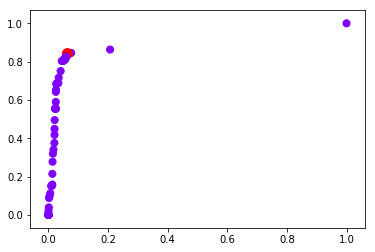

In [5]:
one_minus_specificity_vec = 1 - np.mat(specificity_vec)
one_minus_specificity_vec = np.ravel(one_minus_specificity_vec)

sensitivity_vec = np.ravel(np.mat(sensitivity_vec))

youdens_vec = sensitivity_vec + np.ravel(np.mat(specificity_vec)) - 1

index = np.argmax(youdens_vec)
print(index)

print(sensitivity_vec)
print(specificity_vec)
print(youdens_vec)

colors = np.arange(0,100)
colors = 0.5 * (colors == index) + 0.5

plt.scatter(one_minus_specificity_vec,sensitivity_vec,s = 100 * colors,c = colors,cmap = "rainbow")

In [6]:
X = feature_array
Y = np.array(accident_col_bool)
Y = np.reshape(Y,(len(Y),1))

beta, num_iter, amount_correct, final_prediction, sensitivity, specificity = training(X,Y,decision_boundary=3/100,converge_change=0)
print("Final Coefficients:",np.ravel(beta),"\nNumber of Iterations:",num_iter,"\nPercent Correct:",round(amount_correct,6),"\nSensitivity:",round(sensitivity,3),"\nSpecificity:",round(specificity,3))

Final Coefficients: [-3.29587329 -2.15882905 -1.17451229 -0.02542939 -4.04759967  0.10411059
  0.32973342  0.31788238  1.02533052  0.73625728 -0.92029138 -3.70536423
  0.80066474  3.44313137] 
Number of Iterations: 100000 
Percent Correct: 92.724376 
Sensitivity: 0.846 
Specificity: 0.93


### Data Visualization ###

Hour: 0


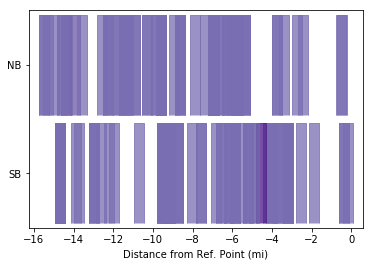

Hour: 1


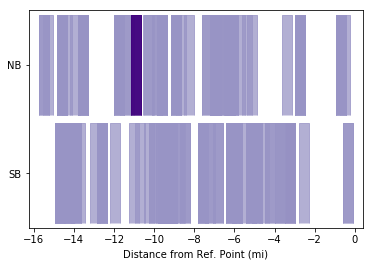

Hour: 2


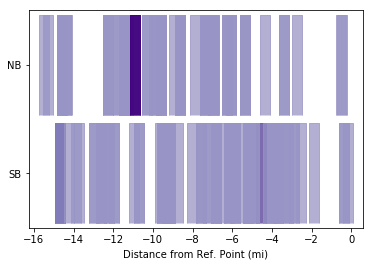

Hour: 3


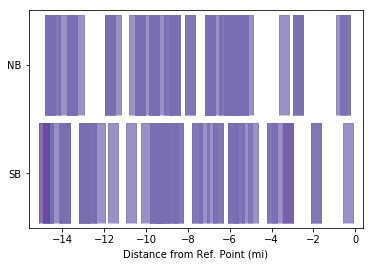

Hour: 4


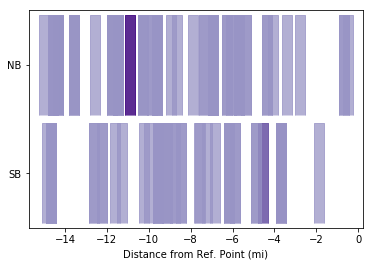

Hour: 5


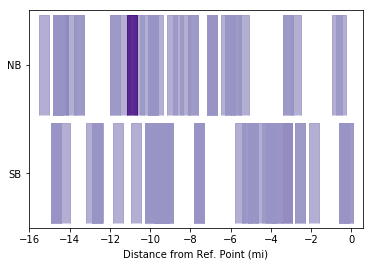

Hour: 6


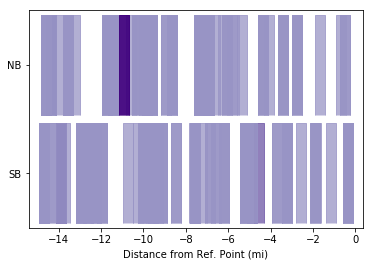

Hour: 7


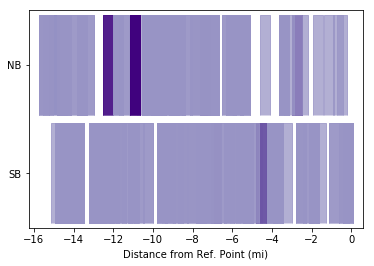

Hour: 8


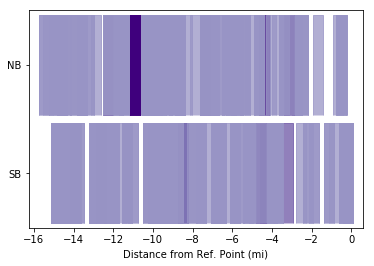

Hour: 9


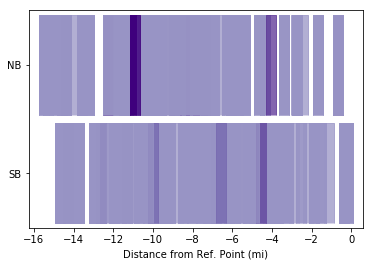

Hour: 10


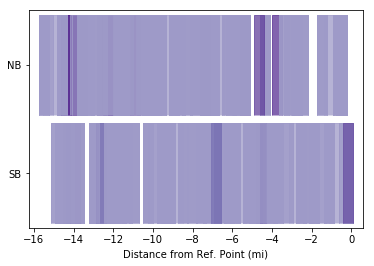

Hour: 11


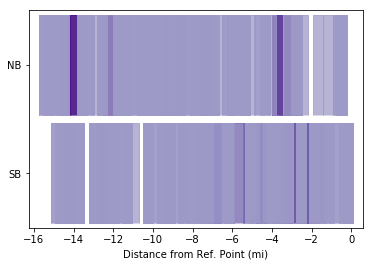

Hour: 12


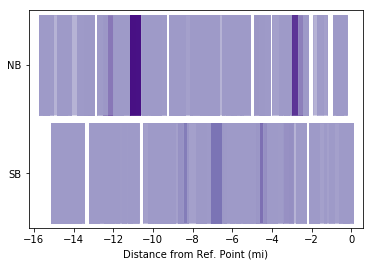

Hour: 13


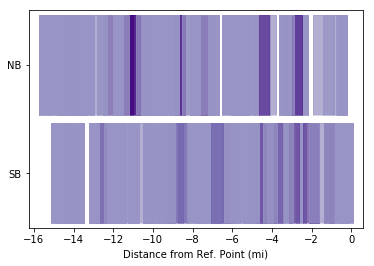

Hour: 14


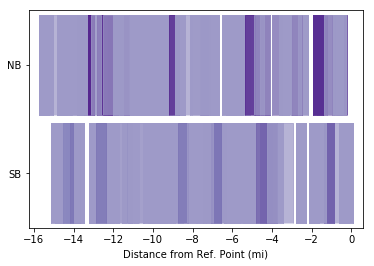

Hour: 15


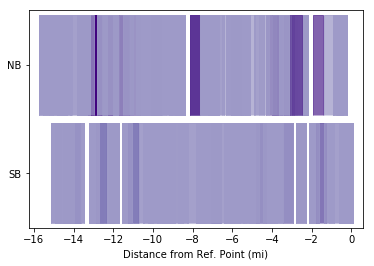

Hour: 16


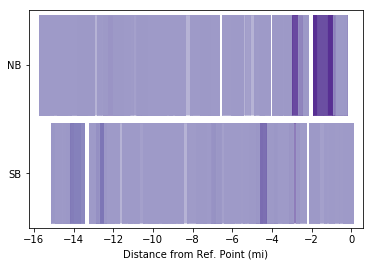

Hour: 17


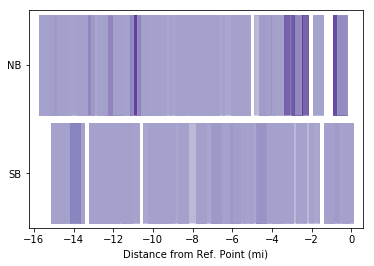

Hour: 18


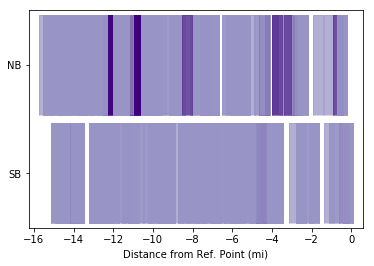

Hour: 19


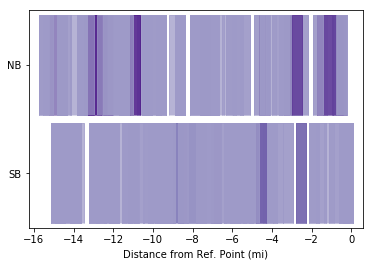

Hour: 20


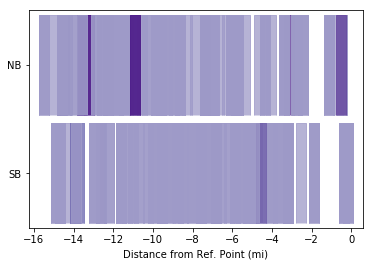

Hour: 21


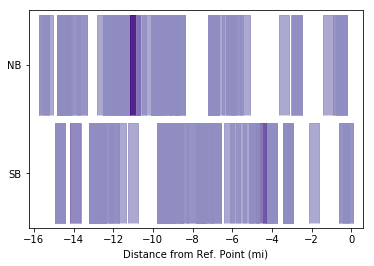

Hour: 22


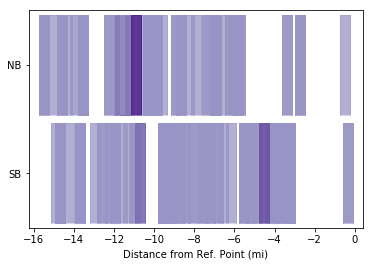

Hour: 23


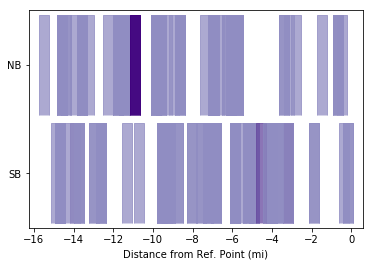

In [7]:
for i in range(0,24):
    hour_bool = np.where(hour_col == i, True, False)
    hour_col_12 = hour_col[hour_bool]
    miles_from_col_12 = miles_from_col[np.squeeze(hour_bool)]
    lat_col_12 = lat_col[np.squeeze(hour_bool)]
    long_col_12 = long_col[np.squeeze(hour_bool)]
    feature_array_12 = feature_array[np.squeeze(hour_bool),...]
    y_12 = accident_col_bool[np.squeeze(hour_bool)]
    probs = final_prediction[np.squeeze(hour_bool)]
    probs = probs // 0.05
    probs = probs.astype('int')
    probs = np.ravel(probs)

    dir_col_12 = incident_dir_col_bool[np.squeeze(hour_bool)]

    print("Hour:",i)

    x = np.ravel(miles_from_col_12)
    y = np.ravel(dir_col_12)

    plt.scatter(x,y,c=probs,vmin = -10, marker=[(-.5,-5),(-.5,5),(.5,5),(.5,-5)],s=10000,cmap="Purples",alpha=0.75)
    plt.yticks(np.arange(2),('SB','NB'))
    plt.ylim((-0.5,1.5))
    plt.xlabel("Distance from Ref. Point (mi)")
    plt.show()